# Qwen2.5-VL-7B Kaggle Pipeline (13-Step VQA Plan)

This notebook targets the Kaggle dual T4 GPU environment and walks through a 13-step pipeline to solve the multi-choice visual question answering task provided in the `2025-ssafy-14` bundle. Each section matches the onsite workflow you will execute: environment audit, dependency setup, data wrangling, Qwen2.5-VL-7B configuration, validation, and submission authoring.


## 1. Session Snapshot & Resources

Capture the GPU, CPU, and Python runtime details. Keeping this log helps debug Kaggle session mismatches and is required before launching heavy vision-language models.


In [1]:
import os
import platform
import shutil
import subprocess
from pathlib import Path

import torch

print(f"Python: {platform.python_version()}")
print(f"Torch: {torch.__version__}")
print(f"CUDA devices: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    for idx in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(idx)
        print(f"  GPU {idx}: {props.name} ({props.total_memory / 1024 ** 3:.1f} GB)")
    try:
        subprocess.run(["nvidia-smi"], check=False)
    except FileNotFoundError:
        print("nvidia-smi command not available.")
else:
    print("CUDA not available; training will run on CPU.")

project_root = Path(os.environ.get("PROJECT_ROOT", Path.home() / "workspace"))
project_root.mkdir(parents=True, exist_ok=True)
print(f"Project root: {project_root.resolve()}")

if project_root.exists():
    total, used, free = shutil.disk_usage(project_root)
    print(
        f"Disk usage for {project_root}: total={total/1e9:.1f} GB | "
        f"used={used/1e9:.1f} GB | free={free/1e9:.1f} GB"
    )


Python: 3.11.14
Torch: 2.4.0+cu124
CUDA devices: 1
  GPU 0: NVIDIA A100-SXM4-40GB (39.5 GB)
Sun Oct 26 04:40:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             46W /  400W |       6MiB /  40960MiB |      0%      Default |
|                                         |     

## 2. Dependency Installation (pip)

Upgrade or pull the exact versions needed for Qwen2.5-VL-7B inference. This list is mirrored in the accompanying documentation so you can track which packages were touched.


In [22]:
%%capture
%pip install --upgrade transformers accelerate einops tiktoken huggingface_hub qwen-vl-utils peft bitsandbytes python-dotenv


## 3. Imports & Global Configuration

Centralise imports, random seeds, plotting rules, and environment flags. Hugging Face tokens are read from the `HF_TOKEN` environment variable (set it in Kaggle Secrets).


In [23]:
import json
import math
import os
import random
import re
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import display
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import torch
from dotenv import load_dotenv
from huggingface_hub import login
from transformers import AutoModelForCausalLM, AutoProcessor

SEED = 99
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["axes.grid"] = False
pd.set_option("display.max_columns", None)

os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.backends.cuda.matmul.allow_tf32 = True
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PROJECT_ROOT = Path(os.environ.get("PROJECT_ROOT", Path.home() / "workspace"))
PROJECT_ROOT.mkdir(parents=True, exist_ok=True)

WORK_DIR = Path(os.environ.get("WORK_DIR", PROJECT_ROOT / "runs"))
WORK_DIR.mkdir(parents=True, exist_ok=True)

ARTIFACT_DIR = WORK_DIR / "artifacts"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

DATA_KEYWORD = os.environ.get("DATA_KEYWORD", "2025-ssafy-14")
ENV_DATA_ROOT = os.environ.get("DATA_ROOT")
ENV_ARCHIVE_PATH = os.environ.get("DATA_ARCHIVE_PATH")
CUSTOM_SEARCH = os.environ.get("DATA_SEARCH_DIR")

load_dotenv(Path.cwd() / ".env")
HF_TOKEN = ""

if HF_TOKEN:
    os.environ["HF_TOKEN"] = HF_TOKEN
    print("[OK] HF_TOKEN loaded from .env/environment.")
else:
    print("[WARN] HF_TOKEN not found. Set it in .env for gated Hugging Face models.")

DATA_SEARCH_DIRS = []
if CUSTOM_SEARCH:
    DATA_SEARCH_DIRS.append(Path(CUSTOM_SEARCH).expanduser())
if ENV_DATA_ROOT:
    DATA_SEARCH_DIRS.append(Path(ENV_DATA_ROOT).expanduser())
DATA_SEARCH_DIRS.extend(
    [
        PROJECT_ROOT,
        PROJECT_ROOT / "data",
        Path.home(),
    ]
)

unique_dirs = []
for path in DATA_SEARCH_DIRS:
    if path is None:
        continue
    path = Path(path).expanduser()
    if path not in unique_dirs:
        unique_dirs.append(path)
DATA_SEARCH_DIRS = unique_dirs


Using device: cuda
[OK] HF_TOKEN loaded from .env/environment.


## 4. Locate & Extract Dataset Archive

Unzip the provided competition bundle inside `/kaggle/working`. The helper covers both archive and already-extracted layouts so you can reuse the notebook without edits.


In [24]:
import zipfile

data_keyword = DATA_KEYWORD
DEFAULT_DATA_ROOT = PROJECT_ROOT / data_keyword
DATA_ROOT = None

if ENV_DATA_ROOT:
    candidate = Path(ENV_DATA_ROOT).expanduser()
    if (candidate / "train.csv").exists():
        DATA_ROOT = candidate
        print(f"Using dataset from DATA_ROOT={DATA_ROOT}")

if DATA_ROOT is None:
    for base in DATA_SEARCH_DIRS:
        csv_path = Path(base).expanduser() / data_keyword / "train.csv"
        if csv_path.exists():
            DATA_ROOT = csv_path.parent
            print(f"Detected dataset at {DATA_ROOT}")
            break

if DATA_ROOT is None:
    archive_candidates = []
    if ENV_ARCHIVE_PATH:
        arch = Path(ENV_ARCHIVE_PATH).expanduser()
        if arch.exists():
            archive_candidates.append(arch)
    for base in DATA_SEARCH_DIRS:
        base = Path(base).expanduser()
        candidate = base / f"{data_keyword}.zip"
        if candidate.exists():
            archive_candidates.append(candidate)
    archive_candidates = sorted({p.resolve() for p in archive_candidates})
    if not archive_candidates:
        raise FileNotFoundError(
            "Dataset not found. Set DATA_ROOT or DATA_ARCHIVE_PATH environment variables."
        )
    archive_path = archive_candidates[0]
    DATA_ROOT = DEFAULT_DATA_ROOT
    DATA_ROOT.mkdir(parents=True, exist_ok=True)
    print(f"Extracting {archive_path} -> {DATA_ROOT}")
    with zipfile.ZipFile(archive_path, "r") as zf:
        zf.extractall(DATA_ROOT)
else:
    archive_path = None
    DATA_ROOT.mkdir(parents=True, exist_ok=True)

print(f"DATA_ROOT resolved to: {DATA_ROOT.resolve()}")
print("Contents:")
for child in sorted(DATA_ROOT.iterdir()):
    print(f"- {child.name}")


Detected dataset at /home/team102/workspace/2025-ssafy-14
DATA_ROOT resolved to: /home/team102/workspace/2025-ssafy-14
Contents:
- .ipynb_checkpoints
- 251023_Baseline.ipynb
- sample_submission.csv
- test
- test.csv
- train
- train.csv


## 5. Load Metadata & Inspect Structure

Read the CSV metadata, attach absolute image paths, and verify the schema expected by downstream steps.


In [25]:
train_df = pd.read_csv(DATA_ROOT / "train.csv")
test_df = pd.read_csv(DATA_ROOT / "test.csv")
sample_submission = pd.read_csv(DATA_ROOT / "sample_submission.csv")

train_df["answer"] = train_df["answer"].str.lower()
train_df["image_path"] = train_df["path"].apply(lambda p: str((DATA_ROOT / p).resolve()))
test_df["image_path"] = test_df["path"].apply(lambda p: str((DATA_ROOT / p).resolve()))

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

display(train_df.head())


Train shape: (3887, 9)
Test shape: (3887, 8)
Sample submission shape: (3887, 2)


,id,path,question,a,b,c,d,answer,image_path
0,train_0001,train/train_0001.jpg,이 사진 속 운동기구가 설치된 장소는 어디일까요?,학교 운동장,공원,헬스장 내부,쇼핑몰 내부,b,/home/team102/workspace/2025-ssafy-14/train/tr...
1,train_0002,train/train_0002.jpg,이 사진에 보이는 전통 한국 건축물은 무엇인가요?,궁궐,성,사찰,한옥,d,/home/team102/workspace/2025-ssafy-14/train/tr...
2,train_0003,train/train_0003.jpg,이 사진에서 보이는 탈것은 무엇인가요?,세발 오토바이,오토바이,자동차,자전거,a,/home/team102/workspace/2025-ssafy-14/train/tr...
3,train_0004,train/train_0004.jpg,이 사진에서 보이는 새는 무엇인가요?,참새,갈매기,백로,오리,c,/home/team102/workspace/2025-ssafy-14/train/tr...
4,train_0005,train/train_0005.jpg,이 사진에서 사람들이 모여서 보고 있는 것은 무엇인가요?,해수욕,바다 축제,불꽃놀이,해돋이,d,/home/team102/workspace/2025-ssafy-14/train/tr...


## 6. Dataset Health Checks

Look at answer balance, ID hygiene, and a sample of image dimensions so we can size model batches safely on T4 GPUs.


In [26]:
label_distribution = train_df["answer"].value_counts().sort_index()
print("Label distribution (train):")
display(label_distribution.to_frame(name="count"))

duplicate_ids = train_df["id"].duplicated().sum()
print(f"Duplicate train IDs: {duplicate_ids}")

null_summary = train_df.isna().sum()
print("Null counts (train):")
display(null_summary[null_summary > 0])

sample_paths = train_df["image_path"].sample(n=min(256, len(train_df)), random_state=SEED)
widths, heights = [], []
for path in sample_paths:
    with Image.open(path) as img:
        w, h = img.size
    widths.append(w)
    heights.append(h)

print(
    f"Sample width px -> mean: {np.mean(widths):.1f}, min: {min(widths)}, max: {max(widths)}"
)
print(
    f"Sample height px -> mean: {np.mean(heights):.1f}, min: {min(heights)}, max: {max(heights)}"
)


Label distribution (train):


,count
answer,
a,964
b,958
c,960
d,1005


Duplicate train IDs: 0
Null counts (train):


Series([], dtype: int64)

Sample width px -> mean: 595.1, min: 224, max: 720
Sample height px -> mean: 656.0, min: 225, max: 720


## 7. Visual Spot Checks

Plot a few random training samples to manually confirm the metadata wiring and to capture qualitative notes about lighting and framing.


/tmp/ipykernel_2223/3631422904.py:13: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2223/3631422904.py:13: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2223/3631422904.py:13: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2223/3631422904.py:13: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2223/3631422904.py:13: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2223/3631422904.py:13: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2223/3631422904.py:13: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  plt.tight_layo

Sample question: 이 음식 구성에서 볼 수 없는 것은 무엇인가요?
A: 비빔국수
B: 김치
C: 떡볶이
D: 김밥


/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49457 

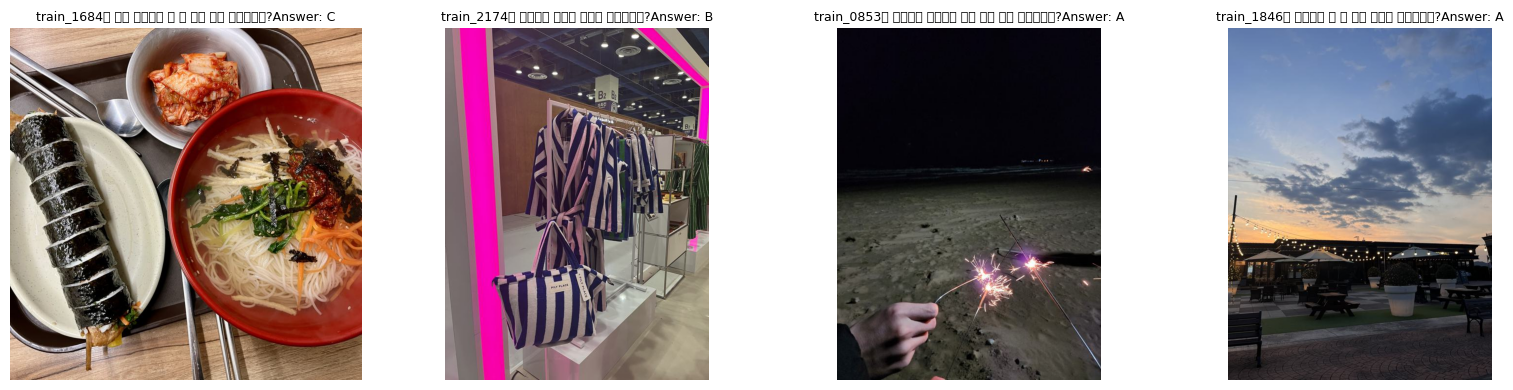

In [27]:
num_examples = 4
fig, axes = plt.subplots(1, num_examples, figsize=(4 * num_examples, 4))
for ax, (_, row) in zip(axes, train_df.sample(num_examples, random_state=SEED).iterrows()):
    with Image.open(row["image_path"]) as img:
        ax.imshow(img)
    ax.axis("off")
    title_lines = [
        row["id"],
        row["question"][:40] + ("..." if len(row["question"]) > 40 else ""),
        f"Answer: {row['answer'].upper()}"
    ]
    ax.set_title("".join(title_lines), fontsize=9)
plt.tight_layout()

sample_row = train_df.sample(1, random_state=SEED).iloc[0]
print("Sample question:", sample_row["question"])
for key in ["a", "b", "c", "d"]:
    print(f"{key.upper()}: {sample_row[key]}")


## 8. Train/Validation Split & Datasets

Create a stratified hold-out set for on-notebook validation. This guards against prompt regressions before spending time on full-test inference.


In [28]:
train_split, val_split = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["answer"],
    random_state=SEED,
)

train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)

print(f"Training rows: {len(train_split)}")
print(f"Validation rows: {len(val_split)}")
print("Validation label balance:")
display(val_split["answer"].value_counts().sort_index())


Training rows: 3498
Validation rows: 389
Validation label balance:


answer
a     96
b     96
c     96
d    101
Name: count, dtype: int64

## 9. Prompt Engineering Helpers

Define the system role, user prompt template, and light utility loaders. These pieces keep the generation cell tidy and make it easy to iterate on instructions.


In [29]:
from PIL import Image, ImageEnhance

SYSTEM_PROMPT = (
    "You are a Korean multiple-choice visual question answering assistant. "
    "Carefully inspect the provided photo taken by everyday people and focus on the key visual cues the question asks for. "
    "Based on actions, objects, places, and overall context, choose exactly one option among a, b, c, d. "
    "Respond strictly as a JSON object like {\"answer\": \"a\"}. "
    "Do not include any explanations or extra text."
)


CHOICE_KEYS = ["a", "b", "c", "d"]
BRIGHTNESS_EPS = 1e-3

def create_user_block(row):
    option_lines = "\n".join(f"{key.upper()}. {row[key]}" for key in CHOICE_KEYS)
    return (
        f"질문: {row['question']}\n"
        f"선택지:\n{option_lines}\n"
        "응답 형식: JSON 예시 {\"answer\": \"a\"} (소문자, 따옴표 유지, 추가 설명 금지)."
    )

def build_messages(row):
    return [
        {"role": "system", "content": [{"type": "text", "text": SYSTEM_PROMPT}]},
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": create_user_block(row)},
            ],
        },
    ]


def load_image(path: str, brightness_factor: float = 1.0) -> Image.Image:
    with Image.open(path) as img:
        img = img.convert("RGB")
    if abs(brightness_factor - 1.0) > BRIGHTNESS_EPS:
        try:
            img = ImageEnhance.Brightness(img).enhance(brightness_factor)
        except Exception:
            pass
    return img

print("Prompt helpers ready.")


Prompt helpers ready.


## 10. Load Qwen2.5-VL-7B

Authenticate (if needed) and pull the Qwen2.5-VL-7B Instruct checkpoint with mixed precision. Flash-Attention is attempted first with a safe fallback.


In [30]:
# 10번: 안전 로딩(위젯 progress 비활성) + 4bit QLoRA + LoRA 세팅
import os, importlib
import torch

# ---- 0) 위젯/프로그레스바 끄기 (traitlets 'layout' KeyError 회피) ----
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"  # HF Hub 진행바 OFF
try:
    # tqdm이 노트북 위젯을 쓰지 않도록 강제로 text 모드로
    import tqdm as _tqdm
    _tqdm.tqdm = importlib.import_module("tqdm.std").tqdm
except Exception:
    pass
try:
    from huggingface_hub.utils import disable_progress_bars
    disable_progress_bars()
except Exception:
    pass

from huggingface_hub import login
from transformers import (
    AutoModelForImageTextToText,   # 권장 클래스 (Vision2Seq 대체)
    AutoProcessor,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

MODEL_ID = "Qwen/Qwen2.5-VL-7B-Instruct"

# ---- 1) 로그인 (이미 환경변수에 토큰이 있으면 스킵돼도 무방) ----
if HF_TOKEN:
    try:
        login(token=HF_TOKEN, add_to_git_credential=False)
    except Exception as exc:
        print(f"[WARN] Hugging Face login skipped: {exc}")
else:
    print("[WARN] Proceeding without HF login; ensure the model is accessible for your account.")

# ---- 2) 프로세서 ----
processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
if hasattr(processor, "tokenizer"):
    # 디코더 전용 모델은 left padding 권장 (추론/학습 경고 방지)
    processor.tokenizer.padding_side = "left"

# ---- 3) 4bit 양자화(QLoRA) ----
compute_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

base_model = AutoModelForImageTextToText.from_pretrained(
    MODEL_ID,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config,
)

# ---- 4) k-bit 학습 준비 + LoRA 어댑터 장착 ----
model = prepare_model_for_kbit_training(base_model)
if hasattr(model, "enable_input_require_grads"):
    model.enable_input_require_grads()
# 학습 중 캐시 사용 비권장(메모리↓)
model.config.use_cache = False

# 타깃 모듈 자동 탐색(없으면 기본셋)
target_candidate_modules = ["q_proj","k_proj","v_proj","o_proj","up_proj","down_proj","gate_proj"]
found = set()
for name, mod in model.named_modules():
    if isinstance(mod, torch.nn.Linear):
        for t in target_candidate_modules:
            if name.endswith(t):
                found.add(t)
found = sorted(found) if found else ["q_proj","k_proj","v_proj","o_proj"]

lora_config = LoraConfig(
    r=16, lora_alpha=32, lora_dropout=0.05,
    bias="none", task_type="CAUSAL_LM",
    target_modules=found,
)
model = get_peft_model(model, lora_config)

# 생성 설정 보정(있으면)
if getattr(model, "generation_config", None) and hasattr(processor, "tokenizer"):
    if model.generation_config.pad_token_id is None:
        model.generation_config.pad_token_id = processor.tokenizer.pad_token_id
    if model.generation_config.eos_token_id is None:
        model.generation_config.eos_token_id = processor.tokenizer.eos_token_id

print("✅ Model loaded with 4-bit quantization and LoRA adapters. Trainable parameters:")
model.print_trainable_parameters()


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

✅ Model loaded with 4-bit quantization and LoRA adapters. Trainable parameters:
trainable params: 47,589,376 || all params: 8,339,756,032 || trainable%: 0.5706


## 11. Fine-Tuning Dataset & Collator
데이터프레임을 LoRA 학습에 맞는 포맷으로 변환하고 배치 단위를 처리하는 collate 함수를 준비합니다.


In [31]:
from torch.utils.data import Dataset
import json
import torch

MAX_SEQUENCE_LENGTH = int(os.environ.get("MAX_SEQUENCE_LENGTH", 1024))


def _parse_float_list(value: str):
    if not value:
        return []
    floats = []
    for chunk in value.split(','):
        chunk = chunk.strip()
        if not chunk:
            continue
        try:
            floats.append(float(chunk))
        except ValueError:
            continue
    return floats


def _parse_range(value: str, default):
    values = _parse_float_list(value)
    if not values:
        return default
    if len(values) == 1:
        return (values[0], values[0])
    return (min(values[0], values[1]), max(values[0], values[1]))


TRAIN_BRIGHTNESS_RANGE = _parse_range(
    os.environ.get("TRAIN_BRIGHTNESS_RANGE", "1.05,1.35"),
    (1.05, 1.35),
)
TRAIN_BRIGHTNESS_PROB = float(os.environ.get("TRAIN_BRIGHTNESS_PROB", 0.8))
TRAIN_BRIGHTNESS_PROB = min(max(TRAIN_BRIGHTNESS_PROB, 0.0), 1.0)

ENSEMBLE_BRIGHTNESS_LEVELS = _parse_float_list(
    os.environ.get("ENSEMBLE_BRIGHTNESS_LEVELS", "1.0,1.15,1.3")
)
ENSEMBLE_BRIGHTNESS_LEVELS = [max(0.1, lvl) for lvl in ENSEMBLE_BRIGHTNESS_LEVELS] or [1.0]
ENSEMBLE_STRATEGY = os.environ.get("ENSEMBLE_STRATEGY", "majority").lower()


class VqaFineTuneDataset(Dataset):
    def __init__(
        self,
        dataframe,
        augment: bool = False,
        brightness_range = TRAIN_BRIGHTNESS_RANGE,
        brightness_prob: float = TRAIN_BRIGHTNESS_PROB,
    ):
        self.df = dataframe.reset_index(drop=True)
        self.augment = augment
        self.brightness_range = brightness_range
        self.brightness_prob = brightness_prob

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        brightness_factor = 1.0
        if self.augment and self.brightness_prob > 0.0:
            if random.random() < self.brightness_prob:
                low, high = self.brightness_range
                brightness_factor = random.uniform(low, high)
        return {
            "image_path": row["image_path"],
            "messages": build_messages(row),
            "answer": str(row["answer"]).lower(),
            "brightness_factor": brightness_factor,
        }


def _build_conversation(sample):
    # 정답 JSON까지 포함한 대화(학습 타깃)
    conversation = sample["messages"] + [
        {
            "role": "assistant",
            "content": [{"type": "text", "text": json.dumps({"answer": sample["answer"]})}],
        }
    ]
    # (1) 프롬프트만
    prompt_text = processor.apply_chat_template(
        sample["messages"], tokenize=False, add_generation_prompt=True
    )
    # (2) 프롬프트 + 정답JSON
    chat_text = processor.apply_chat_template(
        conversation, tokenize=False, add_generation_prompt=False
    )
    return prompt_text, chat_text, sample["image_path"], sample.get("brightness_factor", 1.0)


# ★ 디코더 전용 모델은 left padding 필수
if hasattr(processor, "tokenizer"):
    processor.tokenizer.padding_side = "left"


def fine_tune_collate_fn(batch):
    images, prompts, full_texts = [], [], []

    for sample in batch:
        prompt_text, chat_text, image_path, brightness_factor = _build_conversation(sample)
        images.append(load_image(image_path, brightness_factor=brightness_factor))
        prompts.append(prompt_text)
        full_texts.append(chat_text)

    # 🔹 프롬프트와 전체를 인코딩(프롬프트 길이 계산용 + 전체 입력)
    enc_prompt = processor(
        images=images,
        text=prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_SEQUENCE_LENGTH,
    )
    enc_full = processor(
        images=images,
        text=full_texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_SEQUENCE_LENGTH,
    )

    input_ids = enc_full["input_ids"]
    attn_mask = enc_full["attention_mask"]

    # 기본은 전부 마스크(-100)
    labels = torch.full_like(input_ids, -100)

    # 프롬프트 길이(비전토큰 포함) 추출
    prompt_lens = enc_prompt["attention_mask"].sum(dim=1).tolist()

    # 글자 토큰 ID 헬퍼 (가능하면 'a' 자체 1토큰, 아니면 ' a'의 마지막 토큰 등으로 폴백)
    def _letter_token_id(letter: str):
        ids = processor.tokenizer(letter, add_special_tokens=False).input_ids
        if len(ids) == 1:
            return ids[0]
        ids2 = processor.tokenizer(" " + letter, add_special_tokens=False).input_ids
        return ids2[-1] if len(ids2) > 0 else None

    LETTER2ID = {k: _letter_token_id(k) for k in ["a", "b", "c", "d"]}

    # 각 샘플별로 프롬프트 이후에서 정답 글자 토큰 위치만 라벨로 사용
    for i, sample in enumerate(batch):
        gold_letter = sample["answer"]  # 'a'/'b'/'c'/'d'
        target_id = LETTER2ID.get(gold_letter, None)

        seq = input_ids[i].tolist()
        am  = attn_mask[i].tolist()
        pl  = int(prompt_lens[i])

        # 프롬프트 이후의 유효 인덱스
        valid_idx = [j for j, m in enumerate(am) if m == 1 and j >= pl]

        target_pos = None
        if target_id is not None:
            # 뒤에서부터 찾아 마지막으로 등장하는 글자 토큰을 타깃으로
            for j in reversed(valid_idx):
                if seq[j] == target_id:
                    target_pos = j
                    break

        # 글자 토큰을 못 찾으면 프롬프트 직후 첫 유효 토큰을 폴백
        if target_pos is None:
            target_pos = valid_idx[0] if valid_idx else (len(seq) - 1)

        labels[i, target_pos] = seq[target_pos]

    enc_full["labels"] = labels
    return enc_full



train_dataset = VqaFineTuneDataset(train_split, augment=True)
if len(val_split) <= 128:
    val_eval_df = val_split.copy().reset_index(drop=True)
else:
    val_eval_df = val_split.sample(n=128, random_state=SEED).reset_index(drop=True)
val_dataset = VqaFineTuneDataset(val_eval_df, augment=False)
print(
    f"Train dataset size: {len(train_dataset)} | Eval dataset size: {len(val_dataset)} | "
    f"train_brightness_range={TRAIN_BRIGHTNESS_RANGE} p={TRAIN_BRIGHTNESS_PROB}"
)
print(f"Ensemble brightness levels: {ENSEMBLE_BRIGHTNESS_LEVELS}")


Train dataset size: 3498 | Eval dataset size: 128 | train_brightness_range=(1.05, 1.35) p=0.8
Ensemble brightness levels: [1.0, 1.15, 1.3]


## 12. LoRA Fine-Tuning (1 Epoch)
T4 GPU에서 약 1시간 내에 수렴하도록 4비트 LoRA 학습 설정을 구성합니다.


In [ ]:
# ============================================================
# 12단계: TrainingArguments 하이퍼파라미터 조정 + Trainer 실행 (FAST_MODE 유지)
# ============================================================
import os
import inspect
import torch
from transformers import TrainingArguments, Trainer
from torch.utils.data import Subset

# -------------------------------
# 🔧 0) 빠른 실험 모드 설정 (여기서 직접 조정)
# -------------------------------
FAST_MODE = 0 #os.environ.get("FAST_MODE", str(False)).lower() in {"1", "true", "y", "yes"}
MAX_SAMPLES = int(os.environ.get("FAST_MODE_SAMPLES", 10))

# -------------------------------
# 1) 기본 세팅
# -------------------------------
if hasattr(processor, "tokenizer"):
    processor.tokenizer.padding_side = "left"

OUTPUT_DIR = WORK_DIR / "qwen25vl_lora"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

GPU_MEM_GB = 0.0
if torch.cuda.is_available():
    props = torch.cuda.get_device_properties(0)
    GPU_MEM_GB = props.total_memory / 1024 ** 3

PER_DEVICE_BATCH = int(os.environ.get("PER_DEVICE_BATCH", 12))  # A100 기준 (T4는 2~4)
TARGET_EFFECTIVE_BATCH = int(os.environ.get("TARGET_EFFECTIVE_BATCH", 16))
GRADIENT_ACCUMULATION = max(1, TARGET_EFFECTIVE_BATCH // max(1, PER_DEVICE_BATCH))
EPOCHS = int(os.environ.get("NUM_TRAIN_EPOCHS", 5))
LEARNING_RATE = float(os.environ.get("LEARNING_RATE", 7.5e-6))
WARMUP_RATIO = float(os.environ.get("WARMUP_RATIO", 0.05))

print(
    f"GPU memory: {GPU_MEM_GB:.1f} GB | per_device_batch={PER_DEVICE_BATCH} | "
    f"grad_accum={GRADIENT_ACCUMULATION} | epochs={EPOCHS}"
)

bf16_enabled = torch.cuda.is_available() and torch.cuda.is_bf16_supported()

# -------------------------------
# 2) FAST_MODE에 따른 데이터 제한
# -------------------------------
def limit_dataset(ds, n=MAX_SAMPLES):
    """Dataset을 n개만 선택 (HF Dataset or PyTorch Dataset 모두 지원)"""
    if ds is None:
        return ds
    try:
        return ds.select(range(min(n, len(ds))))  # 🤗 HuggingFace Dataset
    except AttributeError:
        return Subset(ds, range(min(n, len(ds)))) # 🧠 PyTorch Dataset

if FAST_MODE:
    train_dataset = limit_dataset(train_dataset, MAX_SAMPLES)
    if "val_dataset" in locals() and val_dataset is not None:
        val_dataset = limit_dataset(val_dataset, MAX_SAMPLES)
    print(f"⚡ FAST_MODE=ON → {len(train_dataset)} train / {len(val_dataset)} val samples 사용")
else:
    print("🧠 FAST_MODE=OFF → 전체 데이터 사용")

# -------------------------------
# 3) 평가 데이터 유무 확인
# -------------------------------
HAS_EVAL = ("val_dataset" in locals() and val_dataset is not None)
if HAS_EVAL:
    print("ℹ️ Validation dataset 감지 — epoch 종료 시 자동 평가는 비활성화되어 있습니다.")

# -------------------------------
# 4) 옵티마이저 안전 폴백
# -------------------------------
def pick_optim():
    try:
        _ = torch.optim.AdamW([], fused=True)
        return "adamw_torch_fused"   # PyTorch 2.x 이상 GPU 최적화
    except Exception:
        return "adamw_bnb_8bit"      # bitsandbytes fallback

optim_name = pick_optim()

# -------------------------------
# 5) TrainingArguments 설정
# -------------------------------
common_kwargs = dict(
    output_dir=str(OUTPUT_DIR),
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=PER_DEVICE_BATCH,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    warmup_ratio=WARMUP_RATIO,
    lr_scheduler_type="cosine",
    logging_steps=10,
    save_total_limit=3,
    report_to="none",
    bf16=bf16_enabled,
    fp16=not bf16_enabled,
    optim=optim_name,
    dataloader_num_workers=8,
    dataloader_pin_memory=True,
    gradient_checkpointing=False,
    max_grad_norm=0.3,
    remove_unused_columns=False,
)

# eval/evaluation_strategy 키 자동 감지
sig = inspect.signature(TrainingArguments.__init__)
EVAL_KEY = "eval_strategy" if "eval_strategy" in sig.parameters else "evaluation_strategy"

common_kwargs.update({
    EVAL_KEY: "no",
    "save_strategy": "epoch" if HAS_EVAL else "no",
    "load_best_model_at_end": False,
})

# 선택적 고정 step
max_steps_env = os.environ.get("MAX_TRAIN_STEPS")
if max_steps_env:
    common_kwargs["max_steps"] = int(max_steps_env)

training_args = TrainingArguments(**common_kwargs)

# -------------------------------
# 6) Trainer 생성
# -------------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset if HAS_EVAL else None,
    data_collator=fine_tune_collate_fn,
)

# -------------------------------
# 7) 학습 (epoch 종료 평가 없이)
# -------------------------------
train_result = trainer.train()
print("Training metrics:", getattr(train_result, "metrics", {}))
print("(info) Epoch-end evaluation disabled — use validation cell separately when needed.")

# -------------------------------
# 8) 어댑터/프로세서 저장
# -------------------------------
adapter_path = OUTPUT_DIR / "lora_adapter"
model.save_pretrained(adapter_path)
processor.save_pretrained(OUTPUT_DIR / "processor")

print(f"✅ LoRA fine-tuning complete. Adapter weights saved to {adapter_path}")


GPU memory: 39.5 GB | per_device_batch=12 | grad_accum=1 | epochs=5
⚡ FAST_MODE=ON → 10 train / 10 val samples 사용
ℹ️ Validation dataset 감지 — epoch 종료 시 자동 평가는 비활성화되어 있습니다.


/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  #

Step,Training Loss


/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  #

Training metrics: {'train_runtime': 39.2506, 'train_samples_per_second': 1.274, 'train_steps_per_second': 0.127, 'total_flos': 2039108864409600.0, 'train_loss': 0.11832706928253174, 'epoch': 5.0}
(info) Epoch-end evaluation disabled — use validation cell separately when needed.
✅ LoRA fine-tuning complete. Adapter weights saved to /home/team102/workspace/runs/qwen25vl_lora/lora_adapter


## 13. Inference Utilities

Batch the prompts, launch generation, and parse the letter from JSON. The helpers are shared by validation and submission stages.


In [33]:
LETTER_JSON_PATTERN = re.compile(r'"answer"\s*:\s*"([abcd])"', re.I)
LETTER_FALLBACK_PATTERN = re.compile(r"\b([abcd])\b", re.I)

_default_batch = 1
if torch.cuda.is_available():
    try:
        props = torch.cuda.get_device_properties(0)
        gpu_mem_gb = props.total_memory / 1024 ** 3
    except Exception:
        gpu_mem_gb = 0
    if gpu_mem_gb >= 22:
        _default_batch = 6
    elif gpu_mem_gb >= 16:
        _default_batch = 4
    elif gpu_mem_gb >= 12:
        _default_batch = 2
PRED_BATCH_SIZE = int(os.environ.get("PRED_BATCH_SIZE", _default_batch)) or 1
MAX_NEW_TOKENS = int(os.environ.get("MAX_NEW_TOKENS", 16))


def decode_answer_text(text: str) -> str:
    if not text:
        return "a"
    for snippet in re.findall(r"\{.*?\}", text):
        try:
            data = json.loads(snippet)
        except json.JSONDecodeError:
            continue
        answer = data.get("answer")
        if isinstance(answer, str):
            answer = answer.lower().strip()
            if answer in CHOICE_KEYS:
                return answer
    lowered = text.lower()
    match = LETTER_JSON_PATTERN.search(lowered)
    if match:
        return match.group(1)
    match = LETTER_FALLBACK_PATTERN.search(lowered)
    if match:
        return match.group(1)
    return "a"


def _select_answer(counter: Counter) -> str:
    if not counter:
        return "a"
    if ENSEMBLE_STRATEGY == "majority":
        most_common = counter.most_common()
        max_votes = most_common[0][1]
        candidates = [ans for ans, vote in most_common if vote == max_votes]
        for key in CHOICE_KEYS:
            if key in candidates:
                return key
        return candidates[0]
    # 기본값: majority 동작
    most_common = counter.most_common(1)
    return most_common[0][0] if most_common else "a"


def run_inference(records, batch_size: int = PRED_BATCH_SIZE, brightness_levels=None, keep_raw: bool = False):
    model.eval()
    if hasattr(model.config, "use_cache"):
        model.config.use_cache = True

    total_records = len(records)
    brightness_levels = brightness_levels or ENSEMBLE_BRIGHTNESS_LEVELS
    if not brightness_levels:
        brightness_levels = [1.0]
    # 항상 원본 밝기를 포함해 일관성 유지
    if 1.0 not in brightness_levels:
        brightness_levels = [1.0] + list(brightness_levels)

    vote_counters = [Counter() for _ in range(total_records)]
    raw_store = [[] for _ in range(total_records)] if keep_raw else None

    print(f"Inference ensemble brightness levels: {brightness_levels}")

    for start in tqdm(range(0, total_records, batch_size)):
        end = min(start + batch_size, total_records)
        batch_indices = list(range(start, end))
        prompts, images, metadata = [], [], []

        for record_idx in batch_indices:
            row = records[record_idx]
            prompt = processor.apply_chat_template(
                build_messages(row), tokenize=False, add_generation_prompt=True
            )
            img_path = row.get("image_path", row.get("image"))
            for brightness in brightness_levels:
                prompts.append(prompt)
                images.append(load_image(img_path, brightness_factor=brightness))
                metadata.append((record_idx, brightness))

        inputs = processor(
            text=prompts,
            images=images,
            return_tensors="pt",
            padding=True,
        ).to(model.device)

        with torch.inference_mode():
            generated = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                temperature=0.0,
                do_sample=False,
            )

        new_token_ids = generated[:, inputs["input_ids"].shape[-1]:]
        decoded = processor.batch_decode(new_token_ids, skip_special_tokens=True)

        for (record_idx, brightness), response in zip(metadata, decoded):
            answer = decode_answer_text(response)
            vote_counters[record_idx][answer] += 1
            if raw_store is not None:
                raw_store[record_idx].append(f"{brightness:.2f}:{response}")

    final_outputs = []
    for counter in vote_counters:
        final_outputs.append(_select_answer(counter))

    if keep_raw:
        return final_outputs, raw_store
    return final_outputs


print("Inference helpers initialised (ensemble-ready).")


Inference helpers initialised (ensemble-ready).


## 14. Validation Run

Sanity-check the prompt and parsing logic on a stratified slice of the validation split before running the full test sweep.


In [34]:
# 12. Validation Run (ensemble-aware, Kaggle T4 대응)
import torch

if hasattr(processor, "tokenizer"):
    processor.tokenizer.padding_side = "left"

model.eval()
if hasattr(model.config, "use_cache"):
    model.config.use_cache = True

VALIDATION_LIMIT = min(40, len(val_split))  # 너무 많으면 VRAM 터짐
validation_subset = val_split.sample(VALIDATION_LIMIT, random_state=SEED).reset_index(drop=True)
validation_records = validation_subset.to_dict("records")

val_preds, val_raw_responses = run_inference(
    validation_records,
    batch_size=PRED_BATCH_SIZE,
    brightness_levels=ENSEMBLE_BRIGHTNESS_LEVELS,
    keep_raw=True,
)

validation_subset = validation_subset.copy()
validation_subset["prediction"] = val_preds
validation_subset["raw_response"] = [" || ".join(responses) for responses in val_raw_responses]
validation_subset["is_correct"] = (
    validation_subset["answer"].str.lower() == validation_subset["prediction"]
)

val_accuracy = validation_subset["is_correct"].mean()
print(f"✅ Validation accuracy on {len(validation_subset)} samples: {val_accuracy:.4f}")
print("(info) raw_response 열에는 밝기 변형별 출력이 함께 기록됩니다.")

display(validation_subset.head())
display(
    validation_subset[validation_subset["is_correct"] == False][
        ["id", "answer", "prediction", "raw_response"]
    ].head()
)


Inference ensemble brightness levels: [1.0, 1.15, 1.3]


  0%|          | 0/7 [00:00<?, ?it/s]

✅ Validation accuracy on 40 samples: 0.8500
(info) raw_response 열에는 밝기 변형별 출력이 함께 기록됩니다.


,id,path,question,a,b,c,d,answer,image_path,prediction,raw_response,is_correct
0,train_2502,train/train_2502.jpg,이 사진에서 보이는 대표적인 음식점 브랜드는 무엇인가요?,버거킹,맥도날드,롯데리아,KFC,a,/home/team102/workspace/2025-ssafy-14/train/tr...,c,"1.00:{""answer"": ""a""} || 1.15:{""answer"": ""c""} |...",False
1,train_0184,train/train_0184.jpg,이 사진에 보이는 보석 중에서 가장 큰 크기의 반지는 어떤 색상의 보석을 가지고 있나요?,빨간색,초록색,하얀색,파란색,a,/home/team102/workspace/2025-ssafy-14/train/tr...,a,"1.00:{""answer"": ""c""} || 1.15:{""answer"": ""a""} |...",True
2,train_1045,train/train_1045.jpg,사진에 보이는 건물의 창문 색깔은 무엇인가요?,노란색,빨간색,초록색,파란색,c,/home/team102/workspace/2025-ssafy-14/train/tr...,c,"1.00:{""answer"": ""c""} || 1.15:{""answer"": ""c""} |...",True
3,train_3785,train/train_3785.jpg,이 사진에서 보이는 운하가 있는 도시는 어디일까요?,교토,오타루,도쿄,삿포로,b,/home/team102/workspace/2025-ssafy-14/train/tr...,b,"1.00:{""answer"": ""b""} || 1.15:{""answer"": ""b""} |...",True
4,train_2658,train/train_2658.jpg,이 사진에서 보이는 차 주전자를 덮고 있는 것은 무엇인가요?,금속 캡,플라스틱 뚜껑,천으로 된 주전자 덮개,종이 포장지,c,/home/team102/workspace/2025-ssafy-14/train/tr...,c,"1.00:{""answer"": ""c""} || 1.15:{""answer"": ""c""} |...",True


,id,answer,prediction,raw_response
0,train_2502,a,c,"1.00:{""answer"": ""a""} || 1.15:{""answer"": ""c""} |..."
10,train_0025,c,b,"1.00:{""answer"": ""b""} || 1.15:{""answer"": ""b""} |..."
18,train_0512,a,b,"1.00:{""answer"": ""b""} || 1.15:{""answer"": ""b""} |..."
30,train_3195,a,b,"1.00:{""answer"": ""b""} || 1.15:{""answer"": ""b""} |..."
31,train_3032,a,b,"1.00:{""answer"": ""b""} || 1.15:{""answer"": ""b""} |..."


## 15. Full Test Inference & Submission

Generate answers for the official test set and export `submission.csv` under `/kaggle/working` for Kaggle upload.


In [35]:
test_records = test_df.to_dict("records")

test_predictions = run_inference(test_records)
submission = pd.DataFrame({
    "id": test_df["id"],
    "answer": test_predictions,
})

submission_path = WORK_DIR / "submission.csv"
submission.to_csv(submission_path, index=False)
print(f"Saved submission to {submission_path}")

display(submission.head())


Inference ensemble brightness levels: [1.0, 1.15, 1.3]


  0%|          | 0/648 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Notes & Next Steps

- If generation drifts away from lowercase JSON, tighten `SYSTEM_PROMPT` or add few-shot exemplars (image + JSON reply) inside `build_messages`.
- Increase `VALIDATION_LIMIT` once the prompt stabilises to estimate leaderboard expectations more accurately.
- Consider batching with `batch_size=3` if GPU memory allows to speed up the final sweep on the dual T4 setup.
